In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


np.random.seed(1337)

# Dataset Generation 
def make_moons(n_samples=500, noise=0.2, random_state=None):

    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out
    
    # Outer semicircle
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    
    # Inner semicircle
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - 0.5
    
    X = np.vstack([
        np.array([outer_circ_x, outer_circ_y]).T,
        np.array([inner_circ_x, inner_circ_y]).T
    ])
    
    y = np.hstack([np.zeros(n_samples_out), np.ones(n_samples_in)])
    
    # Add noise
    if noise > 0:
        X += np.random.normal(0, noise, X.shape)
    
    # Shuffle
    indices = np.random.permutation(n_samples)
    return X[indices], y[indices]

# Generate datasets
print("Generating datasets...")
X_train, y_train = make_moons(500, noise=0.2, random_state=1337)
X_test, y_test = make_moons(500, noise=0.2, random_state=1338)
X_test_01, y_test_01 = make_moons(500, noise=0.1, random_state=1339)
X_test_03, y_test_03 = make_moons(500, noise=0.3, random_state=1340)

# Standardize using train statistics
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
X_test_01 = (X_test_01 - mean) / std
X_test_03 = (X_test_03 - mean) / std

# Validation split (20%)
val_size = int(0.2 * len(X_train))
X_val = X_train[:val_size]
y_val = y_train[:val_size]
X_train_sub = X_train[val_size:]
y_train_sub = y_train[val_size:]

print(f"Train size: {len(X_train_sub)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

# Helper Functions 
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def initialize_weights(input_size, hidden_size, seed=1337):
    np.random.seed(seed)
    w1 = np.random.randn(input_size, hidden_size) * 0.5
    b1 = np.zeros(hidden_size)
    w2 = np.random.randn(hidden_size, 1) * 0.5
    b2 = np.zeros(1)
    return w1, b1, w2, b2

def forward_pass(X, w1, b1, w2, b2):
    z1 = X @ w1 + b1
    h = sigmoid(z1)
    z2 = h @ w2 + b2
    output = sigmoid(z2)
    return h, output

def compute_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Model 1: MLP with Early Stopping 
def train_mlp_early_stopping(X_train, y_train, X_val, y_val, hidden_size=10, 
                             patience=50, max_epochs=2000, lr=0.1):
    print("\n")
    print("Training MLP with Early Stopping (patience=50)")
    print("="*60)
    
    w1, b1, w2, b2 = initialize_weights(X_train.shape[1], hidden_size)
    
    best_val_loss = float('inf')
    best_weights = None
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(max_epochs):
        # Forward pass
        h, output = forward_pass(X_train, w1, b1, w2, b2)
        train_loss = compute_loss(y_train.reshape(-1, 1), output)
        
        # Backward pass
        dz2 = output - y_train.reshape(-1, 1)
        dw2 = h.T @ dz2 / len(X_train)
        db2 = np.mean(dz2, axis=0)
        
        dh = dz2 @ w2.T
        dz1 = dh * h * (1 - h)
        dw1 = X_train.T @ dz1 / len(X_train)
        db1 = np.mean(dz1, axis=0)
        
        # Update weights
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2
        
        # Validation
        _, val_output = forward_pass(X_val, w1, b1, w2, b2)
        val_loss = compute_loss(y_val.reshape(-1, 1), val_output)
        
        if epoch % 100 == 0:
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch:4d}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = (w1.copy(), b1.copy(), w2.copy(), b2.copy())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    return best_weights, train_losses, val_losses

mlp_es_weights, train_losses, val_losses = train_mlp_early_stopping(
    X_train_sub, y_train_sub, X_val, y_val
)

# Test MLP with early stopping
_, pred_es = forward_pass(X_test, *mlp_es_weights)
_, pred_es_01 = forward_pass(X_test_01, *mlp_es_weights)
_, pred_es_03 = forward_pass(X_test_03, *mlp_es_weights)

auroc_es = roc_auc_score(y_test, pred_es)
auroc_es_01 = roc_auc_score(y_test_01, pred_es_01)
auroc_es_03 = roc_auc_score(y_test_03, pred_es_03)

print(f"\nTest AUROC (noise=0.2): {auroc_es:.4f}")
print(f"Test AUROC (noise=0.1): {auroc_es_01:.4f}")
print(f"Test AUROC (noise=0.3): {auroc_es_03:.4f}")

# Model 2: MLP with L1 Regularization 
def train_mlp_l1(X_train, y_train, X_val, y_val, lambda_l1, hidden_size=10, 
                max_epochs=2000, lr=0.1):

    w1, b1, w2, b2 = initialize_weights(X_train.shape[1], hidden_size, 
                                       seed=1337 + int(lambda_l1 * 1e6))
    
    for epoch in range(max_epochs):
        # Forward pass
        h, output = forward_pass(X_train, w1, b1, w2, b2)
        
        # Backward pass
        dz2 = output - y_train.reshape(-1, 1)
        dw2 = h.T @ dz2 / len(X_train)
        db2 = np.mean(dz2, axis=0)
        
        dh = dz2 @ w2.T
        dz1 = dh * h * (1 - h)
        dw1 = X_train.T @ dz1 / len(X_train)
        db1 = np.mean(dz1, axis=0)
        
        # Update with L1 regularization
        w1 -= lr * (dw1 + lambda_l1 * np.sign(w1))
        b1 -= lr * db1
        w2 -= lr * (dw2 + lambda_l1 * np.sign(w2))
        b2 -= lr * db2
    
    # Calculate sparsity (weights with |w| < 1e-3)
    w1_sparsity = np.mean(np.abs(w1) < 1e-3) * 100
    w2_sparsity = np.mean(np.abs(w2) < 1e-3) * 100
    
    # Validation AUROC
    _, val_pred = forward_pass(X_val, w1, b1, w2, b2)
    val_auroc = roc_auc_score(y_val, val_pred)
    
    return (w1, b1, w2, b2), w1_sparsity, w2_sparsity, val_auroc

print("\n")
print("Training MLP with L1 Regularization")
print("="*60)

lambdas_l1 = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_results = []

for lambda_l1 in lambdas_l1:
    weights, w1_sparse, w2_sparse, val_auroc = train_mlp_l1(
        X_train_sub, y_train_sub, X_val, y_val, lambda_l1
    )
    l1_results.append({
        'lambda': lambda_l1,
        'weights': weights,
        'w1_sparsity': w1_sparse,
        'w2_sparsity': w2_sparse,
        'val_auroc': val_auroc
    })
    print(f"λ={lambda_l1:.1e}: Val AUROC={val_auroc:.4f}, "
          f"Layer1 Sparsity={w1_sparse:.1f}%, Layer2 Sparsity={w2_sparse:.1f}%")

# Select best L1 model based on validation AUROC
best_l1 = max(l1_results, key=lambda x: x['val_auroc'])
print(f"\nBest L1 λ: {best_l1['lambda']:.1e} (Val AUROC: {best_l1['val_auroc']:.4f})")

# Test best L1 model
_, pred_l1 = forward_pass(X_test, *best_l1['weights'])
_, pred_l1_01 = forward_pass(X_test_01, *best_l1['weights'])
_, pred_l1_03 = forward_pass(X_test_03, *best_l1['weights'])

auroc_l1 = roc_auc_score(y_test, pred_l1)
auroc_l1_01 = roc_auc_score(y_test_01, pred_l1_01)
auroc_l1_03 = roc_auc_score(y_test_03, pred_l1_03)

print(f"Test AUROC (noise=0.2): {auroc_l1:.4f}")
print(f"Test AUROC (noise=0.1): {auroc_l1_01:.4f}")
print(f"Test AUROC (noise=0.3): {auroc_l1_03:.4f}")

# Model 3: MLP with L2 Regularization 
def train_mlp_l2(X_train, y_train, lambda_l2, hidden_size=10, 
                max_epochs=2000, lr=0.1):

    w1, b1, w2, b2 = initialize_weights(X_train.shape[1], hidden_size, 
                                       seed=1337 + int(lambda_l2 * 1e6))
    
    for epoch in range(max_epochs):
        # Forward pass
        h, output = forward_pass(X_train, w1, b1, w2, b2)
        
        # Backward pass
        dz2 = output - y_train.reshape(-1, 1)
        dw2 = h.T @ dz2 / len(X_train)
        db2 = np.mean(dz2, axis=0)
        
        dh = dz2 @ w2.T
        dz1 = dh * h * (1 - h)
        dw1 = X_train.T @ dz1 / len(X_train)
        db1 = np.mean(dz1, axis=0)
        
        # Update with L2 regularization
        w1 -= lr * (dw1 + 2 * lambda_l2 * w1)
        b1 -= lr * db1
        w2 -= lr * (dw2 + 2 * lambda_l2 * w2)
        b2 -= lr * db2
    
    return w1, b1, w2, b2

print("\n")
print("Training MLP with L2 Regularization")
print("="*60)


lambdas_l2 = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
l2_results = []

for lambda_l2 in lambdas_l2:
    weights = train_mlp_l2(X_train_sub, y_train_sub, lambda_l2)
    _, val_pred = forward_pass(X_val, *weights)
    val_auroc = roc_auc_score(y_val, val_pred)
    l2_results.append({
        'lambda': lambda_l2,
        'weights': weights,
        'val_auroc': val_auroc
    })
    print(f"λ={lambda_l2:.1e}: Val AUROC={val_auroc:.4f}")

# Select best L2 model
best_l2 = max(l2_results, key=lambda x: x['val_auroc'])
print(f"\nBest L2 λ: {best_l2['lambda']:.1e} (Val AUROC: {best_l2['val_auroc']:.4f})")

# Test best L2 model
_, pred_l2 = forward_pass(X_test, *best_l2['weights'])
_, pred_l2_01 = forward_pass(X_test_01, *best_l2['weights'])
_, pred_l2_03 = forward_pass(X_test_03, *best_l2['weights'])

auroc_l2 = roc_auc_score(y_test, pred_l2)
auroc_l2_01 = roc_auc_score(y_test_01, pred_l2_01)
auroc_l2_03 = roc_auc_score(y_test_03, pred_l2_03)

print(f"Test AUROC (noise=0.2): {auroc_l2:.4f}")
print(f"Test AUROC (noise=0.1): {auroc_l2_01:.4f}")
print(f"Test AUROC (noise=0.3): {auroc_l2_03:.4f}")

# Model 4: Logistic Regression with Polynomial Features 
def add_polynomial_features(X):

    x1, x2 = X[:, 0], X[:, 1]
    return np.column_stack([x1, x2, x1*x2, x1**2, x2**2])

def train_logistic_regression(X_train, y_train, max_epochs=2000, lr=0.1):

    np.random.seed(1337)
    w = np.random.randn(X_train.shape[1], 1) * 0.1
    b = np.zeros(1)
    
    for epoch in range(max_epochs):
        z = X_train @ w + b
        pred = sigmoid(z)
        
        error = pred - y_train.reshape(-1, 1)
        dw = X_train.T @ error / len(X_train)
        db = np.mean(error)
        
        w -= lr * dw
        b -= lr * db
    
    return w, b

print("\n")
print("Training Logistic Regression with Polynomial Features")
print("="*60)

X_train_poly = add_polynomial_features(X_train_sub)
X_test_poly = add_polynomial_features(X_test)
X_test_01_poly = add_polynomial_features(X_test_01)
X_test_03_poly = add_polynomial_features(X_test_03)

w_lr, b_lr = train_logistic_regression(X_train_poly, y_train_sub)

# Test logistic regression
pred_lr = sigmoid(X_test_poly @ w_lr + b_lr)
pred_lr_01 = sigmoid(X_test_01_poly @ w_lr + b_lr)
pred_lr_03 = sigmoid(X_test_03_poly @ w_lr + b_lr)

auroc_lr = roc_auc_score(y_test, pred_lr)
auroc_lr_01 = roc_auc_score(y_test_01, pred_lr_01)
auroc_lr_03 = roc_auc_score(y_test_03, pred_lr_03)

print(f"Test AUROC (noise=0.2): {auroc_lr:.4f}")
print(f"Test AUROC (noise=0.1): {auroc_lr_01:.4f}")
print(f"Test AUROC (noise=0.3): {auroc_lr_03:.4f}")

Generating datasets...
Train size: 400, Val size: 100, Test size: 500


Training MLP with Early Stopping (patience=50)
Epoch    0: Train Loss=0.8082, Val Loss=0.7894
Epoch  100: Train Loss=0.4250, Val Loss=0.4708
Epoch  200: Train Loss=0.3462, Val Loss=0.4161
Epoch  300: Train Loss=0.3210, Val Loss=0.4042
Epoch  400: Train Loss=0.3118, Val Loss=0.4025
Early stopping at epoch 449

Test AUROC (noise=0.2): 0.9472
Test AUROC (noise=0.1): 0.9617
Test AUROC (noise=0.3): 0.9299


Training MLP with L1 Regularization
λ=1.0e-06: Val AUROC=0.9088, Layer1 Sparsity=0.0%, Layer2 Sparsity=0.0%
λ=3.0e-06: Val AUROC=0.9084, Layer1 Sparsity=0.0%, Layer2 Sparsity=0.0%
λ=1.0e-05: Val AUROC=0.9084, Layer1 Sparsity=0.0%, Layer2 Sparsity=0.0%
λ=3.0e-05: Val AUROC=0.9100, Layer1 Sparsity=0.0%, Layer2 Sparsity=0.0%
λ=1.0e-04: Val AUROC=0.9092, Layer1 Sparsity=0.0%, Layer2 Sparsity=0.0%
λ=3.0e-04: Val AUROC=0.9092, Layer1 Sparsity=0.0%, Layer2 Sparsity=0.0%

Best L1 λ: 3.0e-05 (Val AUROC: 0.9100)
Test AUROC (no

In [2]:
from sklearn.metrics import accuracy_score



# EVALUATION AND ANALYSIS (ACCURACY)


# print("\n" + "="*80)
print("EVALUATION AND ANALYSIS - ACCURACY")
# print("="*80)

#  Get Accuracy for MLP + Early Stopping 
pred_es_class = (pred_es >= 0.5).astype(int)
pred_es_01_class = (pred_es_01 >= 0.5).astype(int)
pred_es_03_class = (pred_es_03 >= 0.5).astype(int)

acc_es = accuracy_score(y_test, pred_es_class)
acc_es_01 = accuracy_score(y_test_01, pred_es_01_class)
acc_es_03 = accuracy_score(y_test_03, pred_es_03_class)

print("\nMLP (Early Stopping) Accuracy ")
print(f"Test Accuracy (noise=0.20): {acc_es:.4f}")
print(f"Test Accuracy (noise=0.10): {acc_es_01:.4f}")
print(f"Test Accuracy (noise=0.30): {acc_es_03:.4f}")

# --- 2. Get Accuracy for MLP + L1 ---
pred_l1_class = (pred_l1 >= 0.5).astype(int)
pred_l1_01_class = (pred_l1_01 >= 0.5).astype(int)
pred_l1_03_class = (pred_l1_03 >= 0.5).astype(int)

acc_l1 = accuracy_score(y_test, pred_l1_class)
acc_l1_01 = accuracy_score(y_test_01, pred_l1_01_class)
acc_l1_03 = accuracy_score(y_test_03, pred_l1_03_class)

print(f"\nMLP (L1, λ={best_l1['lambda']:.1e}) Accuracy ")
print(f"Test Accuracy (noise=0.20): {acc_l1:.4f}")
print(f"Test Accuracy (noise=0.10): {acc_l1_01:.4f}")
print(f"Test Accuracy (noise=0.30): {acc_l1_03:.4f}")

#  Get Accuracy for MLP + L2
pred_l2_class = (pred_l2 >= 0.5).astype(int)
pred_l2_01_class = (pred_l2_01 >= 0.5).astype(int)
pred_l2_03_class = (pred_l2_03 >= 0.5).astype(int)

acc_l2 = accuracy_score(y_test, pred_l2_class)
acc_l2_01 = accuracy_score(y_test_01, pred_l2_01_class)
acc_l2_03 = accuracy_score(y_test_03, pred_l2_03_class)

print(f"\nMLP (L2, λ={best_l2['lambda']:.1e}) Accuracy ")
print(f"Test Accuracy (noise=0.20): {acc_l2:.4f}")
print(f"Test Accuracy (noise=0.10): {acc_l2_01:.4f}")
print(f"Test Accuracy (noise=0.30): {acc_l2_03:.4f}")

# Get Accuracy for Logistic Regression 
pred_lr_class = (pred_lr >= 0.5).astype(int)
pred_lr_01_class = (pred_lr_01 >= 0.5).astype(int)
pred_lr_03_class = (pred_lr_03 >= 0.5).astype(int)

acc_lr = accuracy_score(y_test, pred_lr_class)
acc_lr_01 = accuracy_score(y_test_01, pred_lr_01_class)
acc_lr_03 = accuracy_score(y_test_03, pred_lr_03_class)

print("\nLogistic Regression (Polynomial) Accuracy")
print(f"Test Accuracy (noise=0.20): {acc_lr:.4f}")
print(f"Test Accuracy (noise=0.10): {acc_lr_01:.4f}")
print(f"Test Accuracy (noise=0.30): {acc_lr_03:.4f}")

#  Create Summary Table

# Helper function to count parameters from your pure numpy models
def count_parameters(w1, b1, w2, b2):
    return w1.size + b1.size + w2.size + b2.size

# Get parameter counts
mlp_es_params = count_parameters(*mlp_es_weights)
mlp_l1_params = count_parameters(*best_l1['weights'])
mlp_l2_params = count_parameters(*best_l2['weights'])
logreg_params = w_lr.size + b_lr.size # (5 features + 1 bias)

print("\n")
print("FINAL RESULTS TABLE: TEST ACCURACY")
print("="*80)
print(f"{'Model':<30} {'Params':<8} {'Noise=0.20':<12} {'Noise=0.10':<12} {'Noise=0.30':<12}")
print("-" * 74)

print(f"{'MLP (Early Stopping)':<30} {mlp_es_params:<8} {acc_es:<12.4f} {acc_es_01:<12.4f} {acc_es_03:<12.4f}")
print(f"{'MLP (L1 Regularization)':<30} {mlp_l1_params:<8} {acc_l1:<12.4f} {acc_l1_01:<12.4f} {acc_l1_03:<12.4f}")
print(f"{'MLP (L2 Regularization)':<30} {mlp_l2_params:<8} {acc_l2:<12.4f} {acc_l2_01:<12.4f} {acc_l2_03:<12.4f}")
print(f"{'LogReg (Polynomial)':<30} {logreg_params:<8} {acc_lr:<12.4f} {acc_lr_01:<12.4f} {acc_lr_03:<12.4f}")


EVALUATION AND ANALYSIS - ACCURACY

MLP (Early Stopping) Accuracy 
Test Accuracy (noise=0.20): 0.8720
Test Accuracy (noise=0.10): 0.8800
Test Accuracy (noise=0.30): 0.8520

MLP (L1, λ=3.0e-05) Accuracy 
Test Accuracy (noise=0.20): 0.8800
Test Accuracy (noise=0.10): 0.8820
Test Accuracy (noise=0.30): 0.8580

MLP (L2, λ=1.0e-04) Accuracy 
Test Accuracy (noise=0.20): 0.8800
Test Accuracy (noise=0.10): 0.8820
Test Accuracy (noise=0.30): 0.8580

Logistic Regression (Polynomial) Accuracy
Test Accuracy (noise=0.20): 0.8680
Test Accuracy (noise=0.10): 0.8760
Test Accuracy (noise=0.30): 0.8500


FINAL RESULTS TABLE: TEST ACCURACY
Model                          Params   Noise=0.20   Noise=0.10   Noise=0.30  
--------------------------------------------------------------------------
MLP (Early Stopping)           41       0.8720       0.8800       0.8520      
MLP (L1 Regularization)        41       0.8800       0.8820       0.8580      
MLP (L2 Regularization)        41       0.8800       0.8820


PLOTTING DECISION BOUNDARIES (Noise=0.2)


/var/folders/j2/22fxctjx1ll1dg6n9x0xb_y80000gn/T/ipykernel_3234/3252316016.py:36: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, linestyle='--')


Decision boundaries plot saved as 'decision_boundaries_all_models.png'


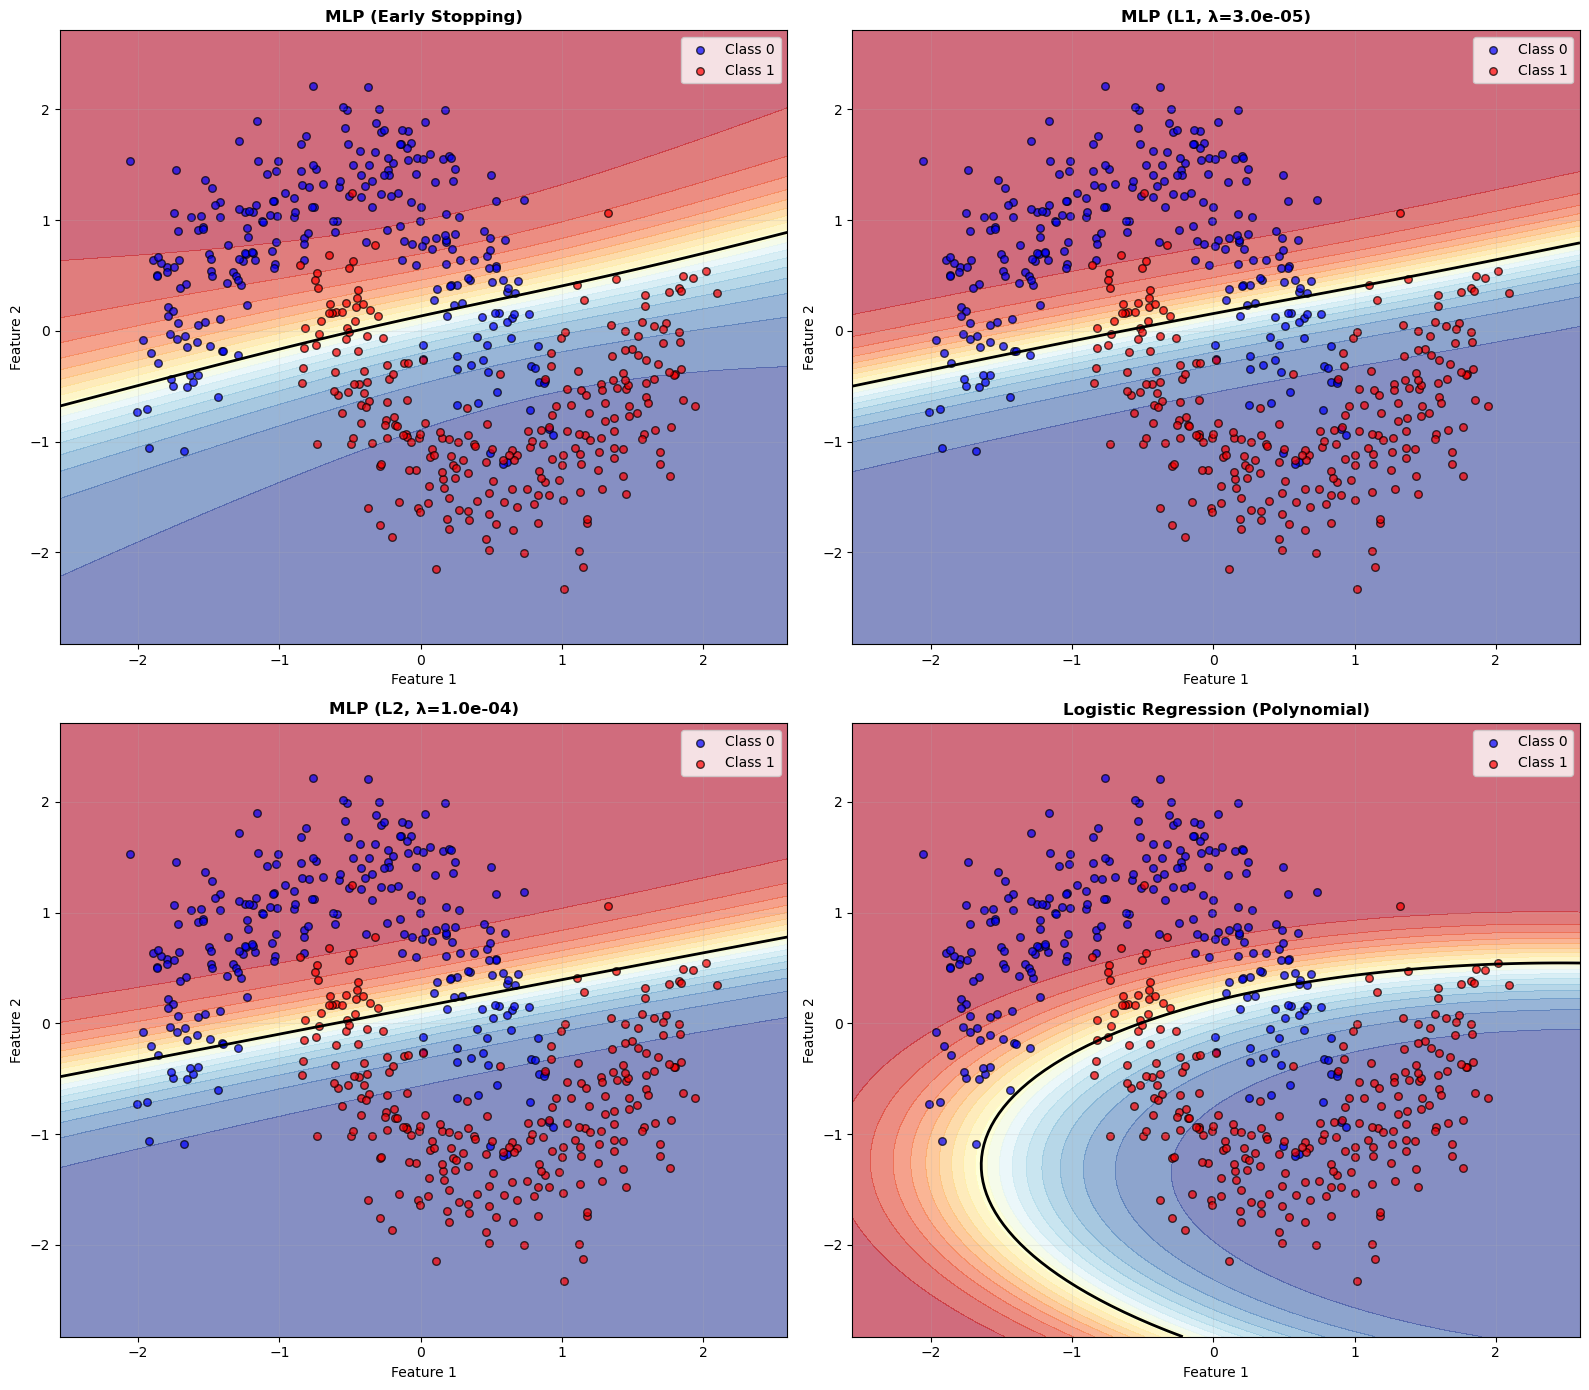

In [3]:

# PLOT DECISION BOUNDARIES (Side-by-Side)


print("\n" + "="*80)
print("PLOTTING DECISION BOUNDARIES (Noise=0.2)")
print("="*80)

def plot_decision_boundary_numpy(ax, model_name, weights, is_mlp=True, poly_func=None):
    # Determine which X, y to use for plotting (original unscaled for meshgrid)
    # The models themselves operate on scaled data
    X_plot = X_train # Use original unscaled training data for scatter plot background
    y_plot = y_train
    
    # Create a meshgrid to plot the decision boundary
    x_min, x_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
    y_min, y_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    
    grid_scaled = (grid - mean) / std 
    
    if is_mlp:

        _, Z = forward_pass(grid_scaled, *weights)
    else:
      
        grid_poly = poly_func(grid_scaled)
        Z = sigmoid(grid_poly @ weights[0] + weights[1]) 
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary and regions
    ax.contourf(xx, yy, Z, levels=np.linspace(0, 1, 20), cmap='RdYlBu', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, linestyle='--')
    
    # Plot the original data points
    ax.scatter(X_plot[y_plot == 0, 0], X_plot[y_plot == 0, 1], color='blue', edgecolors='k', s=30, alpha=0.7, label='Class 0')
    ax.scatter(X_plot[y_plot == 1, 0], X_plot[y_plot == 1, 1], color='red', edgecolors='k', s=30, alpha=0.7, label='Class 1')
    
    ax.set_title(model_name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    ax.grid(True, alpha=0.2)

fig, axes = plt.subplots(2, 2, figsize=(16, 14)) 
axes = axes.flatten()


plot_decision_boundary_numpy(axes[0], 'MLP (Early Stopping)', mlp_es_weights, is_mlp=True)



plot_decision_boundary_numpy(axes[1], f"MLP (L1, λ={best_l1['lambda']:.1e})", best_l1['weights'], is_mlp=True)



plot_decision_boundary_numpy(axes[2], f"MLP (L2, λ={best_l2['lambda']:.1e})", best_l2['weights'], is_mlp=True)


plot_decision_boundary_numpy(axes[3], 'Logistic Regression (Polynomial)', (w_lr, b_lr), 
                             is_mlp=False, poly_func=add_polynomial_features)

plt.tight_layout()
plt.savefig('decision_boundaries_all_models.png', dpi=300, bbox_inches='tight')
print("Decision boundaries plot saved as 'decision_boundaries_all_models.png'")
plt.show()

In [4]:
# Create 70:30 Imbalanced Training Set 
def make_imbalanced(X, y, majority_class=0, ratio=0.7, random_state=1337):
 
 
    np.random.seed(random_state)
    X_major = X[y == majority_class]
    y_major = y[y == majority_class]
    X_minor = X[y != majority_class]
    y_minor = y[y != majority_class]
    
    # Determine number of samples to keep
    n_total = len(y)
    n_major = int(ratio * n_total)
    n_minor = n_total - n_major
    
    # Sample accordingly
    idx_major = np.random.choice(len(X_major), n_major, replace=True)
    idx_minor = np.random.choice(len(X_minor), n_minor, replace=True)
    
    X_imbal = np.vstack([X_major[idx_major], X_minor[idx_minor]])
    y_imbal = np.hstack([y_major[idx_major], y_minor[idx_minor]])
    
    # Shuffle
    perm = np.random.permutation(len(y_imbal))
    return X_imbal[perm], y_imbal[perm]

# Create imbalanced training data (70% class 0, 30% class 1)
X_train_imbal, y_train_imbal = make_imbalanced(X_train_sub, y_train_sub, majority_class=0, ratio=0.7)
print(f"Imbalanced train set size: {len(y_train_imbal)}, Class 0: {(y_train_imbal==0).mean()*100:.1f}%, Class 1: {(y_train_imbal==1).mean()*100:.1f}%")


Imbalanced train set size: 400, Class 0: 70.0%, Class 1: 30.0%


In [5]:
# Retrain MLP (Early Stopping) on Imbalanced Data 
mlp_es_imbal_weights, _, _ = train_mlp_early_stopping(
    X_train_imbal, y_train_imbal, X_val, y_val
)

# Predictions
_, pred_es_imbal = forward_pass(X_test, *mlp_es_imbal_weights)

# Accuracy and AUROC on balanced test set
acc_es_imbal = np.mean((pred_es_imbal >= 0.5).astype(int).flatten() == y_test)
auroc_es_imbal = roc_auc_score(y_test, pred_es_imbal)

print(f"\n[Imbalanced MLP] Test Accuracy: {acc_es_imbal:.4f}, AUROC: {auroc_es_imbal:.4f}")




Training MLP with Early Stopping (patience=50)
Epoch    0: Train Loss=0.5861, Val Loss=0.8055
Epoch  100: Train Loss=0.3809, Val Loss=0.5251
Epoch  200: Train Loss=0.3020, Val Loss=0.4420
Epoch  300: Train Loss=0.2693, Val Loss=0.4149
Epoch  400: Train Loss=0.2548, Val Loss=0.4071
Epoch  500: Train Loss=0.2477, Val Loss=0.4059
Early stopping at epoch 536

[Imbalanced MLP] Test Accuracy: 0.8580, AUROC: 0.9476
